In [1]:
%load_ext autoreload
%autoreload 2

## Data preparation

In [31]:
import numpy as np
import pandas as pd
from biobank_olink.dataset import load_datasets

ol_df, cov_df = load_datasets()

In [32]:
cov_df = cov_df.loc[~(cov_df.BMI.isna() | cov_df.SBP.isna())]
cov_df.sort_values(by='BMI', inplace=True)

In [33]:
col_null_fracs = ol_df.isnull().sum().sort_values(ascending=False) / ol_df.shape[0]
cols_to_drop = col_null_fracs.loc[col_null_fracs > 0.3].index.values
print("dropping {} columns".format(len(cols_to_drop)))
ol_df.drop(columns=cols_to_drop, inplace=True)

dropping 2 columns


In [34]:
row_null_fracs = ol_df.isnull().sum(axis=1).sort_values(ascending=False) / ol_df.shape[1]
rows_to_drop = row_null_fracs.loc[row_null_fracs > 0.3].index.values
print("dropping {} rows".format(len(rows_to_drop)))
ol_df.drop(index=rows_to_drop, inplace=True)

dropping 576 rows


In [35]:
eids = ol_df.index.intersection(cov_df.index)
ol_df = ol_df.loc[eids]
cov_df = cov_df.loc[eids]


def median_impute(df):
    return df.fillna(df.median())


ol_df = median_impute(ol_df)
cov_df = median_impute(cov_df)

print("ol_df shape: {}".format(ol_df.shape))
print("cov_df shape: {}".format(cov_df.shape))

ol_df shape: (39157, 1461)
cov_df shape: (39157, 10)


## Evaluation

In [7]:
n_groups = 3
cov_df.sort_values("SBP", inplace=True)
groups = np.array_split(cov_df.index.values, n_groups)

In [10]:
from scipy.spatial.distance import pdist, squareform


def pair_up_the_most_similar_patients(patients):
    # choose correction cols and normalize them
    correction_cols = ["Sex", "age", "BMI"]
    correction_cov_df = cov_df.loc[patients][correction_cols]
    correction_cov_df = (correction_cov_df - correction_cov_df.mean()) / correction_cov_df.std()
    # compute distances between patients based on the correction cols
    dists = squareform(pdist(correction_cov_df, metric="euclidean"))
    np.fill_diagonal(dists, np.inf)
    dists = pd.DataFrame(dists, index=correction_cov_df.index, columns=correction_cov_df.index)
    # pair up the most similar patients based on the correction cols
    patient_sample = correction_cov_df.index.values
    paired_patients = dists.loc[patient_sample].idxmin(axis=1).reset_index()
    paired_patients.columns = ["p1", "p2"]
    return paired_patients


low, mid, high = groups
paired_patients = pair_up_the_most_similar_patients(high)
paired_patients.head(5)

eid,5419823,5060478,2927623,2725304,5063113,2575356,3623208,3699092,3592128,2578016,...,1403834,5621813,2097511,3089014,5316574,5278793,4529607,4976780,5987443,2368200
eid,,,,,,,,,,,,,,,,,,,,,
5419823,inf,2.449524,3.574933,2.062424,2.575390,2.661089,2.311065,0.636516,1.521451,2.396583,...,2.196880,4.440718,2.278056,3.460902,1.837523,2.918052,2.506392,1.207772,3.286400,2.093410
5060478,2.449524,inf,4.003679,1.370878,0.423833,3.130671,3.928323,2.275958,3.205698,2.630418,...,2.302280,5.157550,1.276840,5.069581,3.762261,3.375362,2.752518,3.179256,3.816643,1.591983
2927623,3.574933,4.003679,inf,2.701181,4.365852,2.753416,4.570975,3.562722,4.320959,3.030871,...,2.597363,1.292959,4.031739,2.190678,2.561050,1.092273,3.292525,3.764835,0.720260,3.408845
2725304,2.062424,1.370878,2.701181,inf,1.685770,2.033476,3.410748,2.029175,2.829718,1.687315,...,1.168383,3.802404,1.469064,3.860782,2.715659,2.004739,1.912422,2.578816,2.452655,1.086019
5063113,2.575390,0.423833,4.365852,1.685770,inf,3.258442,3.888688,2.456984,3.173682,2.721699,...,2.475886,5.488114,1.163450,5.373147,3.985693,3.678519,2.803584,3.232444,4.136525,1.648646


In [ ]:
sbp_map = cov_df.SBP.to_dict()
sbp = paired_patients.applymap(lambda x: sbp_map[x])
sbp = sbp["p1"] - sbp["p2"]

In [49]:
from sklearn.linear_model import LinearRegression

sub_ol_df = ol_df.loc[high]
slopes = [LinearRegression().fit(sub_ol_df[col].values.reshape(-1, 1), sbp.values).coef_.item()
          for col in sub_ol_df.columns]

In [27]:
olink_diffs = ol_df.loc[paired_patients["p1"]].reset_index(drop=True) - ol_df.loc[
    paired_patients["p2"]].reset_index(drop=True)
corrs = [np.corrcoef(sbp, olink_diffs[col])[0, 1] for col in olink_diffs.columns]
corrs = pd.DataFrame(corrs, index=olink_diffs.columns, columns=["corr"])
corrs.sort_values("corr", ascending=False)

,corr
ABCA2,-0.020431
ABL1,0.005264
ABO,0.002502
ACADM,0.036234
ACE,0.076668
...,...
YAP1,-0.000425
YJU2,0.003701
YWHAQ,0.013354
ZBTB17,0.018955


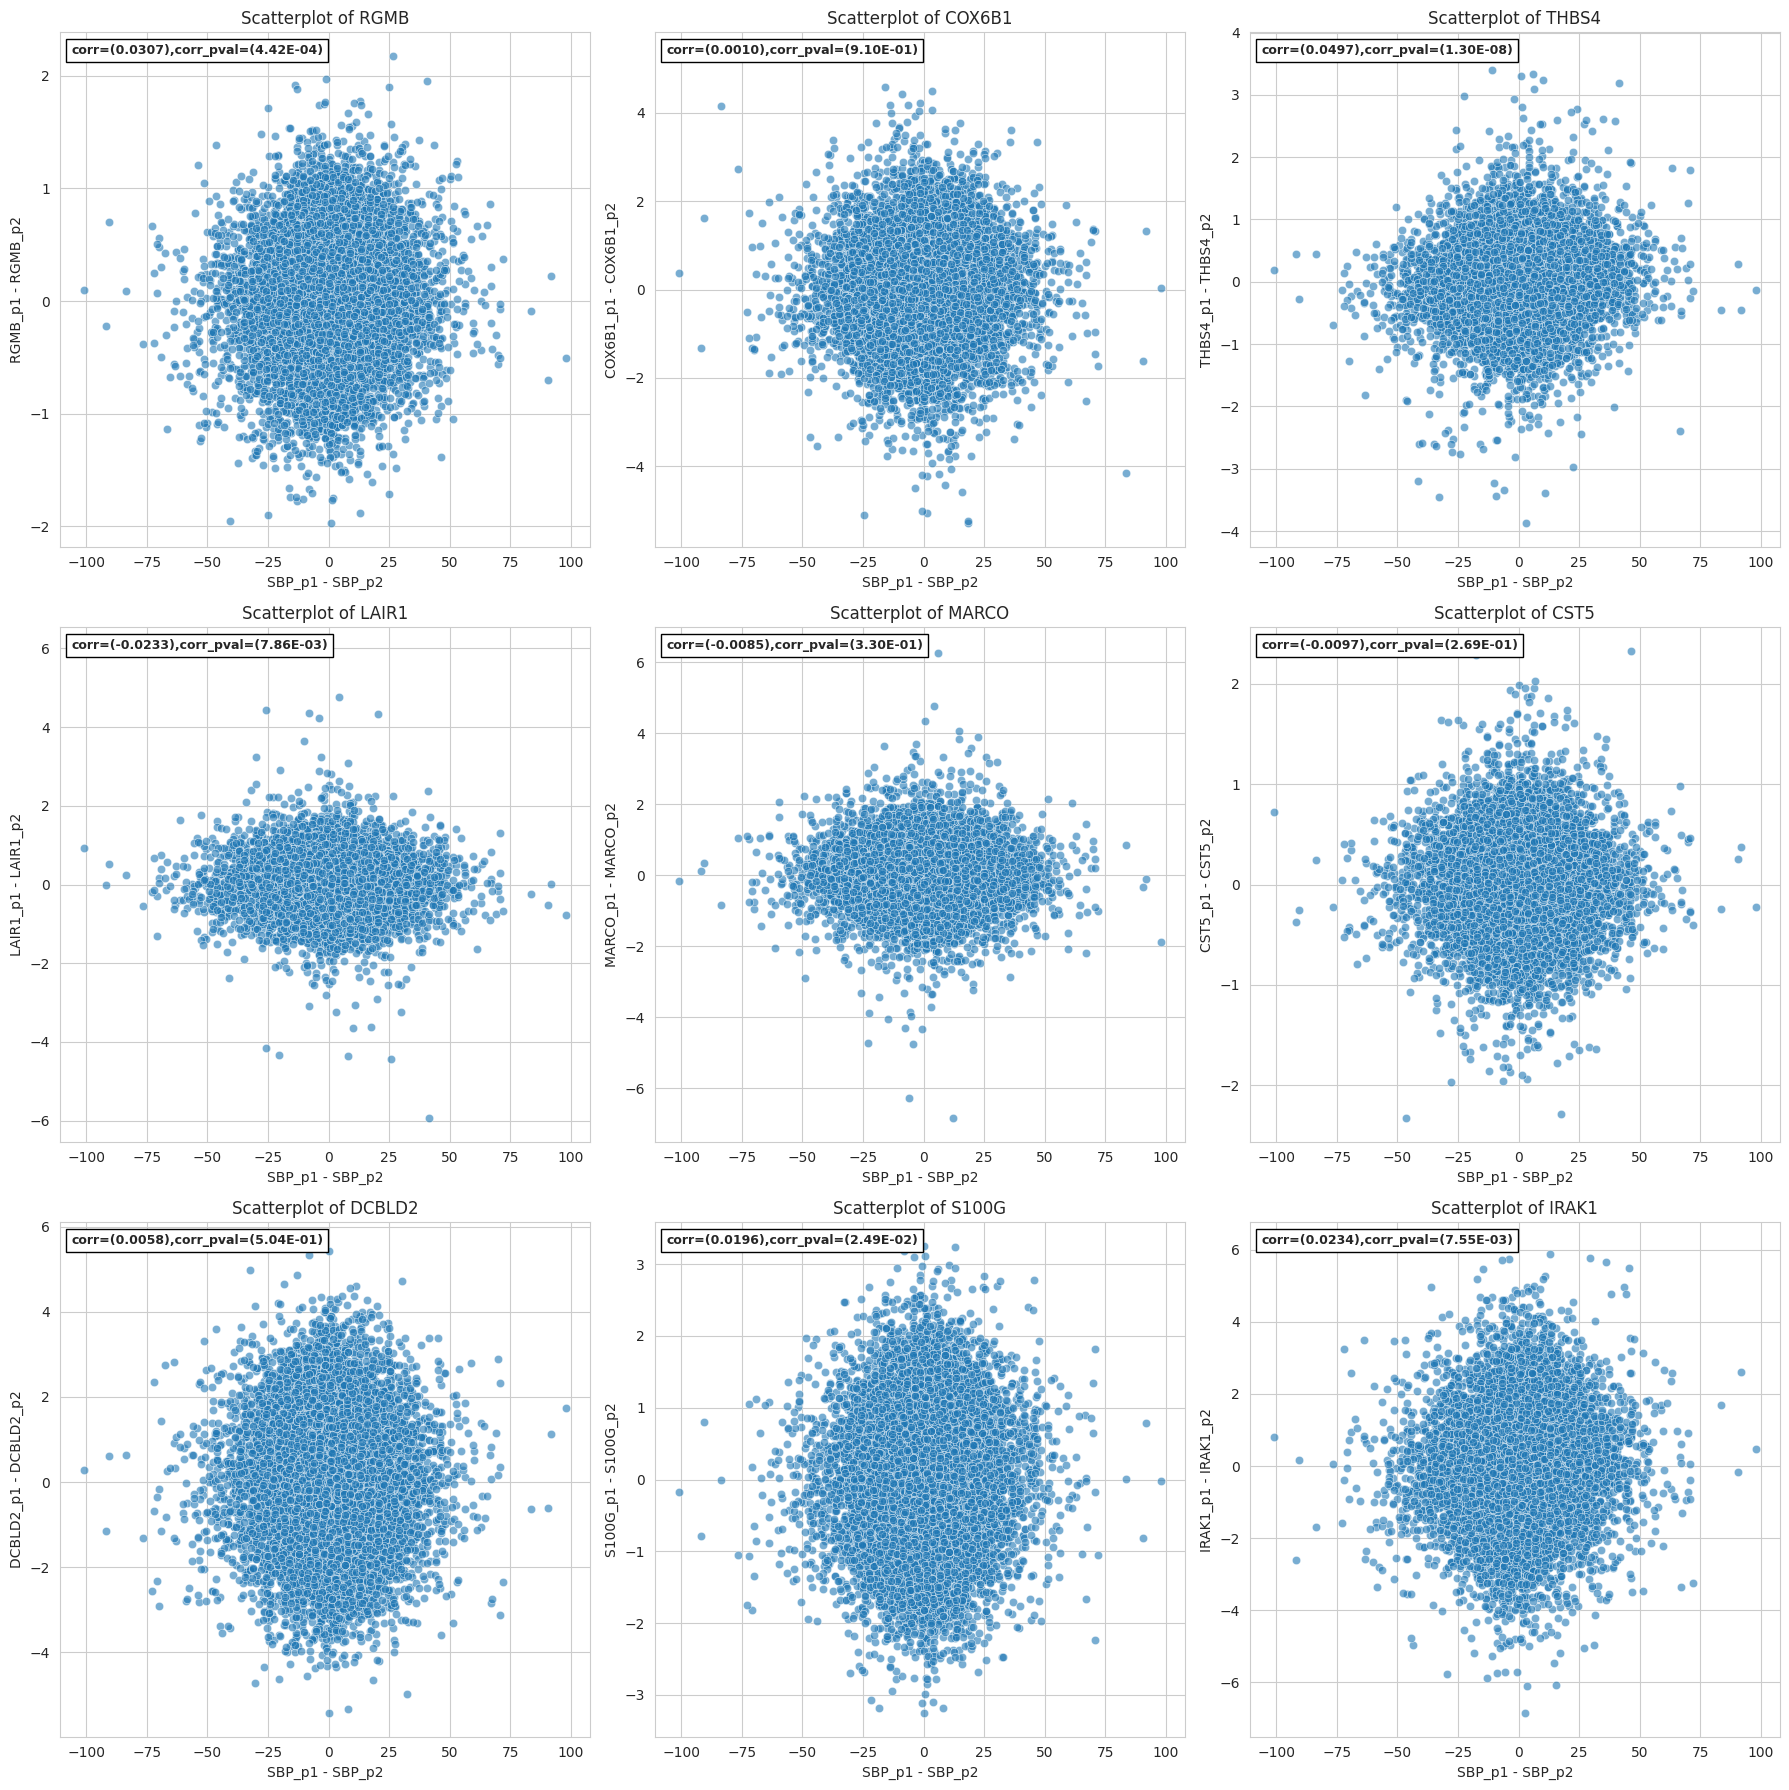

In [12]:
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import matplotlib.pyplot as plt


def viz_relations(df):
    grid_size = int(np.ceil(np.sqrt(len(df.columns))))

    plt.figure(figsize=(6 * grid_size, 6 * grid_size))

    sbp_map = cov_df.SBP.to_dict()
    sbp = paired_patients.applymap(lambda x: sbp_map[x])
    sbp = sbp["p1"] - sbp["p2"]

    for index, column in enumerate(df.columns):
        olink_map = ol_df.loc[:, column].to_dict()
        olink = paired_patients.applymap(lambda x: olink_map[x])
        olink = olink["p1"] - olink["p2"]

        ax = plt.subplot(grid_size, grid_size, index + 1)
        sns.scatterplot(x=sbp, y=olink, alpha=0.6, ax=ax)
        plt.title(f'Scatterplot of {column}')
        plt.xlabel('SBP_p1 - SBP_p2')
        plt.ylabel(f"{column}_p1 - {column}_p2")
        corr, p_value = pearsonr(sbp, olink)
        anc = AnchoredText(f"corr=({corr:.4f}),corr_pval=({p_value:.2E})", loc="upper left",
                           frameon=True, prop=dict(size=9, fontweight="bold"))
        ax.add_artist(anc)

    plt.tight_layout()


viz_relations(ol_df.sample(9, axis=1))